In [1]:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
from IPython.display import Markdown
import numpy as np
import seaborn as sns
# import the tensiometer tools that we need:
import tensiometer
from tensiometer import utilities
from tensiometer import gaussian_tension
from tensiometer import mcmc_tension
from numpy.linalg import inv, det

2022-07-07 01:58:49.193268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-07 01:58:49.193355: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
off_size=5

In [3]:
#All PTA Datasets are available at 
#https://drive.google.com/drive/folders/1Wy3NcSQBWanafkTBbHFzqPv-3Kg1pjMx?usp=sharing
Ae,ge=np.loadtxt('original/epta.csv').transpose()
Ap,gp=np.loadtxt('original/ppta.csv').transpose()
An,gn=np.loadtxt('original/ng.csv').transpose()
Ai,gi=np.loadtxt('original/ipta.csv').transpose()

In [4]:
names = ['logA','gamma']
names2=['EPTA','PPTA','NG12.5','IPTA']
del_names=['delta_logA','delta_gamma']
epta_arr=[Ae,ge];ppta_arr=[Ap,gp];ng_arr=[An,gn];ipta_arr=[Ai,gi]
arr=[epta_arr,ppta_arr,ng_arr,ipta_arr]

In [5]:
def gaussian_log_like(Arr):
    A1,gamma1=Arr
    mean=np.array([np.mean(A1),np.mean(gamma1)])
    invcov=inv(np.cov([A1,gamma1]))
    _diff=np.array([A1,gamma1]).transpose()-mean
    return (_diff.dot(invcov)*_diff).sum(axis=1)


In [6]:
epta=MCSamples(samples=np.array(epta_arr).transpose(),loglikes=gaussian_log_like(epta_arr),label='EPTA',names = names)
ppta=MCSamples(samples=np.array(ppta_arr).transpose(),loglikes=gaussian_log_like(ppta_arr),label='PPTA',names = names)
ng=MCSamples(samples=np.array(ng_arr).transpose(),loglikes=gaussian_log_like(ng_arr),label='NG12.5',names = names)
ipta=MCSamples(samples=np.array(ipta_arr).transpose(),loglikes=gaussian_log_like(ipta_arr),label='IPTA',names = names)

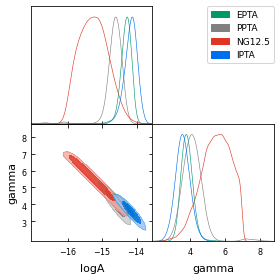

In [7]:
g = plots.get_subplot_plotter()
g.triangle_plot([epta,ppta,ng,ipta], filled=True)
# plt.savefig('PTAcomparison.pdf',dpi=1000)

In [8]:
for i,chain in enumerate([epta,ppta,ng,ipta]):
    chain.chain_offsets =np.linspace(0,len(arr[i][0]),off_size,dtype = int)

In [9]:
Arr=[epta,ppta,ng,ipta]


In [10]:
mcmc_tension.n_threads = 1
# create the distribution of the parameter differences:

def Diff_chain(A1,A2):
    diff_chain = mcmc_tension.parameter_diff_chain( A1, A2, boost=1)
    
    shift_probability, shift_lower, shift_upper = mcmc_tension.kde_parameter_shift_2D_fft(diff_chain, feedback=0)
    return diff_chain, shift_probability, shift_lower, shift_upper

In [11]:
from tqdm import tqdm

In [12]:
A=[[],[],[],[],[],[]]
C1=[[],[],[],[],[],[]]
DIFF_CHAIN=[]
count=0
for i in range(4):
    for j in tqdm(range(i+1,4)):
        #print('Compare '+str(names2[i])+' & '+str(names2[j])+':')
        DIFF_CHAIN.append(Diff_chain(Arr[i],Arr[j]))
        chain,val,lv,fv=DIFF_CHAIN[count]
        A[count].append(chain)
        
        A[count][0].updateSettings({'contours': [0.68, 0.95, val]})
        C1[count].append(str(names2[i])+' & '+str(names2[j]))
        count+=1

B,C=[],[]
for i in range(6):
    B.append(A[i][0])
    C.append(C1[i][0])

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]
0it [00:00, ?it/s]


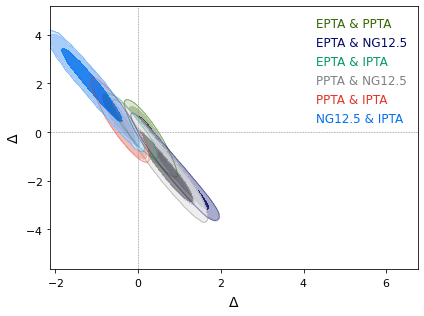

In [13]:
g = plots.get_single_plotter()
g.settings.num_plot_contours = 3
g.plot_2d(B,['delta_logA','delta_gamma'], filled=True);
g.add_legend(C, colored_text=True);
g.add_x_marker(0)
g.add_y_marker(0)
plt.savefig('diff.jpg',dpi=1000)

In [14]:
data=np.zeros((4,4),dtype=object)
count=0
for i in range(4):
    for j in range(i+1,4):
        org=DIFF_CHAIN[count][1]
        data[i][j]="{:.3f}".format(org),[("{:.1e}".format(DIFF_CHAIN[count][k]-org)) for k in range(2,4)]
        
        count+=1
    for j in range(0,i+1):
        data[i][j]='-'
import pandas as pd
pta=['EPTA','PPTA','NANOGrav','IPTA']
pd.DataFrame(data, index=pta, columns=pta).style.set_caption('Degree of disagreement in percentage')

,EPTA,PPTA,NANOGrav,IPTA
EPTA,-,"('0.895', ['-1.7e-04', '1.7e-04'])","('0.958', ['-2.2e-04', '2.2e-04'])","('0.233', ['-1.1e-03', '1.1e-03'])"
PPTA,-,-,"('0.611', ['-2.7e-04', '2.7e-04'])","('0.933', ['-1.4e-04', '1.4e-04'])"
NANOGrav,-,-,-,"('0.976', ['-1.7e-04', '1.7e-04'])"
IPTA,-,-,-,-


In [15]:
data=np.zeros((4,4),dtype=object)
count=0
for i in range(4):
    for j in range(i+1,4):
        org=utilities.from_confidence_to_sigma(DIFF_CHAIN[count][1])
        data[i][j]="{:.3f}".format(org),[("{:.1e}".format(utilities.from_confidence_to_sigma(
            DIFF_CHAIN[count][k])-org)) for k in range(2,4)]
        
        count+=1
    for j in range(0,i+1):
        data[i][j]='-'
import pandas as pd
pta=['EPTA','PPTA','NANOGrav','IPTA']
pd.DataFrame(data, index=pta, columns=pta).style.set_caption('Degree of disagreement in 'r'$\sigma$:')

,EPTA,PPTA,NANOGrav,IPTA
EPTA,-,"('1.622', ['-7.9e-04', '7.9e-04'])","('2.038', ['-2.2e-03', '2.2e-03'])","('0.296', ['-1.4e-03', '1.4e-03'])"
PPTA,-,-,"('0.861', ['-4.9e-04', '4.9e-04'])","('1.830', ['-9.3e-04', '9.3e-04'])"
NANOGrav,-,-,-,"('2.256', ['-2.7e-03', '2.7e-03'])"
IPTA,-,-,-,-


In [16]:
data=np.zeros((4,4),dtype=object)
count=0
for i in range(4):
    for j in range(i+1,4):
        org=1-DIFF_CHAIN[count][1]
        data[i][j]="{:.3f}".format(org),[("{:.1e}".format((1-DIFF_CHAIN[count][k])-org)) for k in range(2,4)]
        
        count+=1
    for j in range(0,i+1):
        data[i][j]='-'
import pandas as pd
pta=['EPTA','PPTA','NANOGrav','IPTA']
pd.DataFrame(data, index=pta, columns=pta).style.set_caption('Degree of agreement in percentage')

,EPTA,PPTA,NANOGrav,IPTA
EPTA,-,"('0.105', ['1.7e-04', '-1.7e-04'])","('0.042', ['2.2e-04', '-2.2e-04'])","('0.767', ['1.1e-03', '-1.1e-03'])"
PPTA,-,-,"('0.389', ['2.7e-04', '-2.7e-04'])","('0.067', ['1.4e-04', '-1.4e-04'])"
NANOGrav,-,-,-,"('0.024', ['1.7e-04', '-1.7e-04'])"
IPTA,-,-,-,-


In [17]:
data=np.zeros((4,4),dtype=object)
count=0
for i in range(4):
    for j in range(i+1,4):
        org=utilities.from_confidence_to_sigma(1-DIFF_CHAIN[count][1])
        data[i][j]="{:.3f}".format(org),[("{:.1e}".format(utilities.from_confidence_to_sigma((1-DIFF_CHAIN[count][k]))-org)) for k in range(2,4)]
        
        count+=1
    for j in range(0,i+1):
        data[i][j]='-'
import pandas as pd
pta=['EPTA','PPTA','NANOGrav','IPTA']
pd.DataFrame(data, index=pta, columns=pta).style.set_caption('Degree of agreement in 'r'$\sigma$:')

,EPTA,PPTA,NANOGrav,IPTA
EPTA,-,"('0.132', ['2.2e-04', '-2.1e-04'])","('0.052', ['2.8e-04', '-2.7e-04'])","('1.192', ['2.8e-03', '-2.8e-03'])"
PPTA,-,-,"('0.509', ['3.9e-04', '-3.9e-04'])","('0.084', ['1.8e-04', '-1.7e-04'])"
NANOGrav,-,-,-,"('0.030', ['2.1e-04', '-2.1e-04'])"
IPTA,-,-,-,-


In [18]:
utilities.from_confidence_to_sigma(.024)

0.03008407662018911